Number of frames:  1951
Converting video..

Done extracting frames.
1951 frames extracted
It took 36 seconds forconversion.


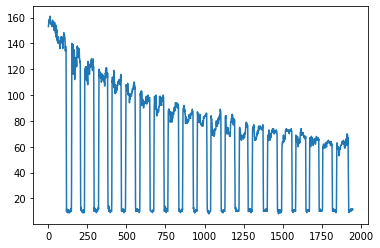

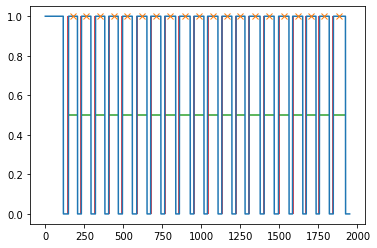

Word length :  58.0
Pick Frame length :  50


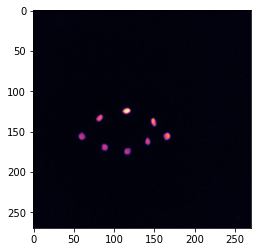

(270, 270, 5)


In [9]:
import cv2
import numpy as np
import matplotlib as plt
import pandas as pd
import time
import tqdm
import os
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import matplotlib.pyplot as plt
from scipy.signal import chirp, find_peaks, peak_widths


def start_pint(x):
    peaks, _ = find_peaks(x, height=-40)
    results_half = peak_widths(x, peaks, rel_height=0.5)
    plt.plot(x)
    plt.plot(peaks, x[peaks], "x")
    plt.hlines(*results_half[1:], color="C2")
    result = peaks-results_half[0]/2
    plt.vlines(result,0,1,color='red')
    plt.show()
    plt.close()
    print("Word length : ",np.min(results_half[0]))
    return result

def video_to_frames(input_loc):
    time_start = time.time()
    cap = cv2.VideoCapture(input_loc)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    image_max = []
    image_value=np.array([],dtype=int)
    print ("Converting video..\n")
    while cap.isOpened():
        ret, frame = cap.read()
        if np.max(frame)>25 :
            image_value = np.append(image_value, 1)
        else :
            image_value = np.append(image_value, 0)
        image_max.append(np.max(frame))
        count = count + 1
        if (count > (video_length-1)):
            time_end = time.time()
            cap.release()
            print ("Done extracting frames.\n%d frames extracted" % count)
            print ("It took %d seconds forconversion." % (time_end-time_start))
            break
    plt.plot(image_max)
    plt.show()
    plt.close()
    return np.round(start_pint(image_value)).astype('int')

def make_dataset(input_loc, output_loc, start_point, jump=10, number=5):
    try:
        os.mkdir(output_loc)
    except OSError:
        pass
    cap = cv2.VideoCapture(input_loc)
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    count = 0
    all_point = []
    dataset = []
    for i in start_point:
        for _ in range(number):
            all_point.append(i+jump)
            i+=jump
    while cap.isOpened():
        ret, frame = cap.read()
        if count in all_point:
            grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)[50:950, 400:1300]
            grayFrame = cv2.resize(grayFrame,dsize=(0,0),fx=0.3, fy=0.3)
            dataset.append(grayFrame)
        else:
            pass
        count = count + 1
        if (count > (video_length-1)):
            cap.release()
            break
    print("Pick Frame length : ", jump*number)
    return dataset, number

def stack_array(data, number):
    all_data = []
    for i in range(int(np.shape(data)[0]/number)):
        j = number * i
        """If data number change stack change"""
        all_data.append(np.stack([data[0+j], data[1+j], data[2+j], data[3+j], data[4+j]], axis = 2))
    return all_data


input_loc = r'./data/raw_data/fracture_1.mp4'
output_loc =  r'./data/fracture/'
array = video_to_frames(input_loc)
dataset = make_dataset(input_loc, output_loc, array)
result = stack_array(dataset[0], dataset[1])
plt.imshow(dataset[0][0],cmap='magma')
plt.show()
plt.close()
print(np.shape(result[0]))
np.save(output_loc+'/fracture',result)